In [ ]:
def f1(x1,x2,x3,t):
  dx1dt = x2
  return dx1dt

def f2(x1,x2,x3,t):
##  dx2dt = (t**2 - 3.0)*x1
  dx2dt = -x1
  return dx2dt


In [ ]:
from time import process_time
import matplotlib.pyplot as plt
betaList = [0., 0.]
def solve(t0,tn,n):
  mt = 0
  mnt = 1
  datSet = 0
  beta = betaList.pop(0)
    
##Plotting parameters
  r = []
  y = []
  z = []
  zz = []

  
  while betaList != []:
    mt = 0
    datSet += 1
    
    
    while (mt<mnt):   
      x1= 1.0
      x2 = 0.0
      
      mt += 1
      dt=(tn-t0)/n
      t = t0
      
      x3 , k31, k32, k33 = 0., 0., 0., 0.
      for i in range (n):

         k11 = dt*f1(x1,x2,x3,t)
         k21 = dt*f2(x1,x2,x3,t)
         k12 = dt*f1(x1+0.5*k11,x2+0.5*k21,x3+0.5*k31,t+0.5*dt)
         k22 = dt*f2(x1+0.5*k11,x2+0.5*k21,x3+0.5*k31,t+0.5*dt)
         k13 = dt*f1(x1+0.5*k12,x2+0.5*k22,x3+0.5*k32,t+0.5*dt)
         k23 = dt*f2(x1+0.5*k12,x2+0.5*k22,x3+0.5*k32,t+0.5*dt)
         k14 = dt*f1(x1+k13,x2+k23,x3+k33,t+dt)
         k24 = dt*f2(x1+k13,x2+k23,x3+k33,t+dt)
         x1 += (k11+2*k12+2*k13+k14)/6
         x2 += (k21+2*k22+2*k23+k24)/6
         t += dt

         # plotting data
         r = [t] + r
         y = [x1] + y
         z = [x2]+ z
                  
    ##   One set done, start next beta from the list
    beta = betaList.pop(0)


  fig, ay = plt.subplots()
  ay.plot(r,y, 'b',  label = "displacement f")
  ay.plot(r, z, 'r', label = "f'")

  legend = ay.legend(loc='best', shadow=True, fontsize='x-small', title='spring load')
  legend.get_frame().set_facecolor('white')
  plt.show()
##

## All the plots are stored in images directory of run directory  
if __name__ == '__main__':
  beta = 0.0
  t1_start = process_time()

  solve(0, 16, 400)
  
  t1_stop = process_time()
  print('Elapsed run time in secs: ' , t1_stop - t1_start)


This was a solution for spring vibration with mass m and stiffness k. The following equation was solved with k/m set to one.
\begin{eqnarray} x'' +(k/m)*x &=& 0 \\ x(0) &=& 1 \\ x'(0) &=& 0  \end{eqnarray}
It is clearly seen from the plot that displacement function, in blue, goes thru three maxima and three minima. If we try to solve 
this problem with neural network schemes which minimizes a loss function, reference https://https://kitchingroup.cheme.cmu.edu/blog/2017/11/27/Solving-BVPs-with-a-neural-network-and-autograd/,
we are going to run into a problem. The doctrine of minimization is just one minimum during a training. This is obvious as for more than one minimum, the optimizer which keeps on trying to minimize several spots, with gradient descent method,  stops converging. 
Let us examine this case with one of the optimizer methods. This is very well written, very robust, non shooting, gradient descent minimization method. It has been applied to many fluid and thermal heat transfer problems with great success. 


In [ ]:
import autograd.numpy.random as npr
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]


def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))




In [ ]:
from autograd import grad, elementwise_grad

layer_sizes=[1, 8, 1]
params = init_random_params(0.1, layer_sizes)

def f(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)    
    return outputs

# Derivatives
fp = elementwise_grad(f, 1)
fpp = elementwise_grad(fp, 1)
fppp = elementwise_grad(fpp, 1)
eta = np.linspace(0, 4.*np.pi).reshape((-1, 1))

## This is the function we seek to minimize
def objective(params, step):
    # These should all be zero at the solution
    zeq = fpp(params, eta) +  f(params, eta) 
    bc0 = f(params, 0.0) - 1.0 # equal to zero at solution
    bc1 = fp(params, 0.0)  # equal to zero at solution
    return np.mean(zeq**2) + bc0**2 + bc1**2

from autograd.misc.optimizers import adam
def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))

params = adam(grad(objective), params,
              step_size=0.001, num_iters=10000, callback=callback)




In [ ]:
print('f(0) = {}'.format(f(params, 0.0)))
print('fp(0) = {}'.format(fp(params, 0.0)))
print('fp(inf) = {}'.format(f(params, 4.*np.pi)))


import matplotlib.pyplot as plt
plt.plot(eta, f(params, eta), 'b', label = "f" )
plt.plot(eta, fp(params, eta), 'g', label = "f'" )
plt.xlim([0, 14])
plt.ylim([-1., 1.])
plt.legend()
plt.show()

This is obviously we did not expect. The process did not converge and the method could not find even one minimum. Since I am not a machine language scholar, as a user I would like to get some engineering fix for the problem(you may call it band aid fix). I tried various things, the one fix which worked was to split the domain in half, and solve the same equation in each domain with the connected boundary condition. The following code illustrates the method.

In [1]:
!pip install autograd
import autograd.numpy.random as npr
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]


def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))

layer_sizes=[1, 8, 1]
params = init_random_params(0.1, layer_sizes)

def f(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)    
    return outputs


# Derivatives
fp = elementwise_grad(f, 1)
fpp = elementwise_grad(fp, 1)
fppp = elementwise_grad(fpp, 1)

## This is the function we seek to minimize
def objective(params, step):
    # These should all be zero at the solution
    zeq = fpp(params, eta) +  f(params, eta) 
    bc0 = f(params, 0.0) - 1.0 # equal to zero at solution
    bc1 = fp(params, 0.0)  # equal to zero at solution
    return np.mean(zeq**2) + bc0**2 + bc1**2


def ft(params2, inputs):
    "Neural network functions"
    for W2, b2 in params2:
        outputs = np.dot(inputs-2.*np.pi, W2) + b2
        inputs = swish(outputs)    
    return outputs

layer_sizes=[1, 8, 1]
##params = init_random_params(0.1, layer_sizes)
params2 = init_random_params(0.1, layer_sizes)

ftp = elementwise_grad(ft, 1)
ftpp = elementwise_grad(ftp, 1)
ftppp = elementwise_grad(ftpp, 1)

eta = np.linspace(0, 2.*np.pi).reshape((-1, 1))
eta2 = np.linspace(2.*np.pi, 4.*np.pi).reshape((-1, 1))

def objective2(params2, step):
    zeq2 = ftpp(params2, eta2) +  ft(params2, eta2) 
    bc0 = ft(params2, 2.*np.pi) - f(params,2.*np.pi) # equal to zero at solution
    bc1 = ftp(params2, 2.*np.pi) - fp(params, 2.*np.pi) # equal to zero at solution
    return np.mean(zeq2**2) + bc0**2 + bc1**2

from autograd.misc.optimizers import adam
def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))
def callback2(params2, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective2(params2, step)))
for k in range(5):
  params = adam(grad(objective), params,
              step_size=0.001, num_iters=4000, callback=callback)
              
  params2 = adam(grad(objective2), params2,
              step_size=0.001, num_iters=4000, callback=callback2)
print('fp(inf) = {}'.format(ft(params2, 4.*np.pi)))

Iteration   0 objective [[ 0.64211262]]


You are using pip version 9.0.3, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Iteration 1000 objective [[ 0.09156821]]
Iteration 2000 objective [[ 0.04183957]]
Iteration 3000 objective [[ 0.03775889]]
Iteration   0 objective [[ 12.36297387]]
Iteration 1000 objective [[ 0.16906304]]
Iteration 2000 objective [[ 0.05107493]]
Iteration 3000 objective [[ 0.03534324]]
Iteration   0 objective [[ 0.03458221]]
Iteration 1000 objective [[ 0.02978379]]
Iteration 2000 objective [[ 0.0166298]]
Iteration 3000 objective [[ 0.00757374]]
Iteration   0 objective [[ 0.35196022]]
Iteration 1000 objective [[ 0.07708875]]
Iteration 2000 objective [[ 0.04200501]]
Iteration 3000 objective [[ 0.0236884]]
Iteration   0 objective [[ 0.00411309]]
Iteration 1000 objective [[ 0.00274919]]
Iteration 2000 objective [[ 0.00159919]]
Iteration 3000 objective [[ 0.00097012]]
Iteration   0 objective [[ 0.04598597]]
Iteration 1000 objective [[ 0.02170865]]
Iteration 2000 objective [[ 0.01456138]]
Iteration 3000 objective [[ 0.00884915]]
Iteration   0 objective [[ 0.00063304]]
Iteration 1000 objectiv

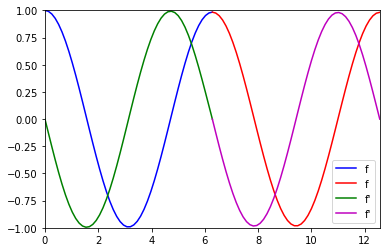

In [2]:
import matplotlib.pyplot as plt
plt.plot(eta, f(params, eta), 'b', label = "f" )
plt.plot(eta2, ft(params2, eta2), 'r', label = "f")
plt.plot(eta, fp(params, eta), 'g', label = "f'" )
plt.plot(eta2, ftp(params2, eta2), 'm', label = "f'" )
plt.xlim([0, 4.*np.pi])
plt.ylim([-1., 1.])
plt.legend()
plt.show()


Great. Hopefully we resolved one way to solve such problems. Now we will look into another way to solve Shrodinger equation, reference https://kitchingroup.cheme.cmu.edu/blog/2017/11/29/Solving-an-eigenvalue-differential-equation-with-a-neural-network/.
Author Prof. Kitchin gives an elaborate presentation of the method for several values of eigenvalue associated with the wave.  As a refresher I quote the scope of the problem mentioned in that reference.
" The 1D harmonic oscillator is described here. It is a boundary value differential equation with eigenvalues. If we let let ω=1, m=1, and units where ℏ=1. then, the governing differential equation becomes:

$(-0.5 \frac{d^2\psi(x)}{dx^2} + (0.5 x^2 - E) \psi(x) = 0)$

with boundary conditions:$ (\psi(-\infty) = \psi(\infty) = 0)$

We can further stipulate that the probability of finding the particle over this domain is equal to one: $(\int_{-\infty}^{\infty} \psi^2(x) dx = 1)$. In this set of equations, $(E)$ is an eigenvalue, which means there are only non-trivial solutions for certain values of $(E)$.

Our goal is to solve this equation using a neural network to represent the wave function. This is a different problem than the one here or here because of the eigenvalue. This is an additional adjustable parameter we have to find. Also, we have the normalization constraint to consider, which we did not consider before."

I am going to concentrate on the first excited state with eigenvalue E of 1.5. The use of some initial wave shape to train or pretrain the gradient function takes out the beauty of the method. I am going to propose either using  additional boundary conditions at the min and max value of the function or just using the pobability function. This works beautifully with no prior knowledge of the solution. Here is my code to do this. 
Remember to restart and clear the kernel when solving a new problem. Thanks for patiently reading this long blog. I will appreciate constructive comments.

In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]


def swish(x):
    "see https://arxiv.org/pdf/1710.05941.pdf"
    return x / (1.0 + np.exp(-x))


def f(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)    
    return outputs

    
# Here is our initial guess of params:
layer_sizes=[1, 8, 1]
params = init_random_params(0.1, layer_sizes)

# Derivatives
fp = elementwise_grad(f, 1)
fpp = elementwise_grad(fp, 1)

eta = np.linspace(-5,5,50)[:, None]



# This is the function we seek to minimize
def objective(params, step):
    zeq = -0.5*fpp(params, eta) + (0.5* eta**2 - 1.5065724128094344 )* f(params, eta)
    bc0 = f(params, -5.0)  # equal to zero 
    bc1 = f(params, -1.0) + 0.644288 # value at 1 
    bc2 = f(params,  1.0) - 0.644288
    bc3 =  f(params, 5.0)
    bc1, bc2 = 0., 0.
    y1 = f(params, eta)**2
    prob = np.sum((y1[1:] + y1[0:-1]) / 2 * (eta[1:] - eta[0:-1]))
    return np.mean(zeq**2) + bc0**2 +   bc2**2 + bc1**2 + bc3**2 + (1. -prob)**2

def callback(params, step, g):
    if step % 1000 == 0:
        print("Iteration {0:3d} objective {1}".format(step,
                                                      objective(params, step)))
       
params = adam(grad(objective), params,
              step_size=0.001, num_iters=15000, callback=callback)


psi = (1/np.pi)**0.25 * np.sqrt(2) * eta * np.exp(-eta**2 / 2)

print('f(0) = {}'.format(f(params, -5.)))
print('fp(0) = {}'.format(fp(params, -5.)))
print('f(5) = {}'.format(f(params, 5.0)))
                                                      
import matplotlib.pyplot as plt
plt.plot(eta, f(params, eta), 'b', label = "prediction")
plt.plot(eta, psi, 'r', label = "analytical")
##plt.ylabel('psi & truth')
##plt.xlim([0, 14])
##plt.ylim([-1., 1.])
plt.legend()
plt.show()